In [1]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#metricas de evaluacion
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import completeness_score
from sklearn.metrics import homogeneity_score

def calculate_metrics(y_true,y_pred):
    f1 = f1_score(y_true,y_pred,average="weighted")
    p = precision_score(y_true,y_pred,average=None,labels=[0,1]) #1 confirmado y 0 false positivo
    r = recall_score(y_true,y_pred,average=None,labels=[0,1])
    #c = completeness_score(y_true, y_pred)
    #h = homogeneity_score(y_true,y_pred)
    return f1,p,r #f1score,completness and homogeneite

In [3]:
#fijo para todos los datos
df_labels_train = pd.read_csv('Datos_split/koi_labels_train.csv')
df_labels_val = pd.read_csv('Datos_split/koi_labels_val.csv')
df_labels_test = pd.read_csv('Datos_split/koi_labels_test.csv')

y_train = ((df_labels_train["NExScI Disposition"]=="CONFIRMED")*1).values
y_val = ((df_labels_val["NExScI Disposition"]=="CONFIRMED")*1).values
y_test = ((df_labels_test["NExScI Disposition"]=="CONFIRMED")*1).values
df_labels_train.head()

,NExScI Disposition,KOI Name,Kepler Name,Planet Radius,Stellar Radius,Metallicity,Stellar Mass
0,CONFIRMED,K00889.01,Kepler-75 b,10.51,0.843,-0.08,0.821
1,FALSE POSITIVE,K01009.01,NaN,1.17,0.751,-0.20,0.727
2,FALSE POSITIVE,K07621.01,NaN,1.86,1.187,-0.12,0.864
3,FALSE POSITIVE,K04162.01,NaN,9.19,5.302,-0.10,2.050
4,FALSE POSITIVE,K07622.01,NaN,1.50,0.620,-0.20,0.607


In [6]:
#datos
df_algo_train = pd.read_csv('NeuralNetwork/koi_light_curves_statistic_period_train.csv',header=None)
df_algo_val = pd.read_csv('NeuralNetwork/koi_light_curves_statistic_period_val.csv',header=None)
df_algo_test = pd.read_csv('NeuralNetwork/koi_light_curves_statistic_period_test.csv',header=None)

#df_algo_train = pd.read_csv('Resample/koi_light_curves_resample_train.csv',header=None)
#df_algo_val = pd.read_csv('Resample/koi_light_curves_resample_val.csv',header=None)
#df_algo_test = pd.read_csv('Resample/koi_light_curves_resample_test.csv',header=None)


largo = 5
estadisticos= 5 #5 #maximo,minimo,media,std
X_train = np.reshape(df_algo_train.values,(df_algo_train.shape[0],largo,estadisticos))
X_val = np.reshape(df_algo_val.values,(df_algo_val.shape[0],largo,estadisticos))
X_test = np.reshape(df_algo_test.values,(df_algo_test.shape[0],largo,estadisticos))
X_train.shape

(4044, 5, 5)

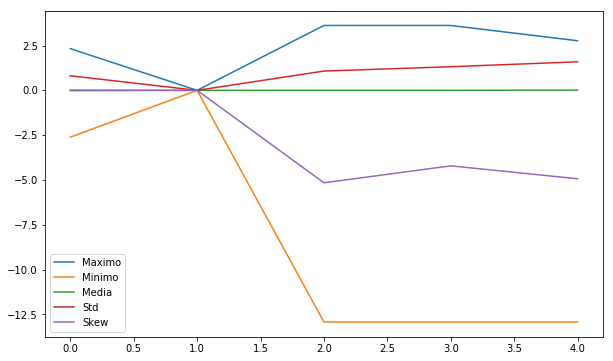

In [7]:
plt.figure(figsize=(10,6))
plt.plot(X_train[0,:,0],label="Maximo")
plt.plot(X_train[0,:,1],label="Minimo")
plt.plot(X_train[0,:,2],label="Media")
plt.plot(X_train[0,:,3],label="Std")
plt.plot(X_train[0,:,4],label="Skew")
plt.legend()
plt.show()

/etc/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


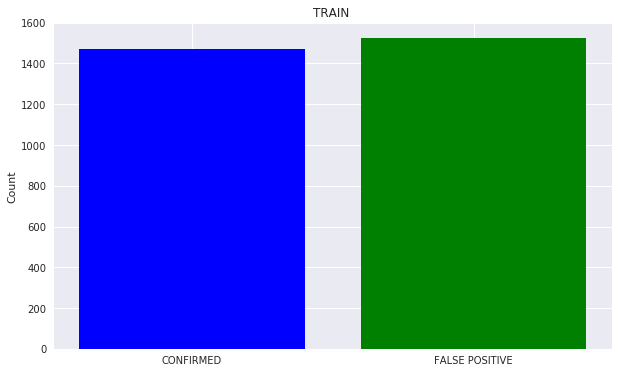

In [8]:
mask = y_train!=0 #elemntos que se quedan

for i in range(len(mask)):
    element = mask[i]
    if element == False:
        if np.random.rand(1)[0] < 0.6 : #deja aprox 60% de los falsos positivos
            mask[i] = True
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10,6))
plt.title("TRAIN ")
plt.bar(0, np.sum(y_train[mask]==1),color="blue")
plt.bar(1, np.sum(y_train[mask]==0),color="green")
plt.xticks([0,1],["CONFIRMED","FALSE POSITIVE"])
plt.ylabel("Count")

In [9]:
#SUBSAMPLE
ysample_train = y_train[mask]
Xsample_train = X_train[mask]
Xsample_train.shape

(2995, 5, 5)

In [10]:
#calculo de estadisticos ("fit")
minimos = Xsample_train.min(axis=(0,1), keepdims=True)
maximos = Xsample_train.max(axis=(0,1), keepdims=True)


#normalize between 0 and 1 every statisctic
Xstd_train = (Xsample_train-minimos) / (maximos-minimos)
Xstd_val = (X_val-minimos) / (maximos-minimos)
Xstd_test = (X_train-minimos) / (maximos-minimos)

In [11]:
Xstd_train.shape

(2995, 5, 5)

In [61]:
Xstd_test.max(axis=(0,1))

array([ 1.])

In [16]:
from keras.layers import Input, LSTM, RepeatVector,GRU,Dense, Bidirectional
from keras.models import Model,Sequential
from keras.callbacks import TensorBoard

batch_size=16
timesteps= largo
input_dim = estadisticos

model = Sequential()

model.add(GRU(20, input_shape=(timesteps, input_dim), return_sequences=True,dropout=0.2))
#model.add(GRU(5, return_sequences=True,activation='sigmoid))
model.add(GRU(10, return_sequences=False))

#model.add(GRU(5, return_sequences=False,activation='sigmoid))

model.add(Dense(5, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.summary()

#rmsprop
model.compile(loss='binary_crossentropy', optimizer='adam')
model.fit(Xstd_train, ysample_train, epochs=100, batch_size=batch_size,
          validation_data=(Xstd_val,y_val))

#deeper
#encoded = LSTM(units = 10, return_sequences=True)(inputs) #probar sigmoid
#encoded = LSTM(units = 25, return_sequences=True,dropout=0.2)(inputs) #probar sigmoid

#encoded = LSTM(latent_dim, return_sequences=False, activation='sigmoid')(encoded)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 5, 20)             1560      
_________________________________________________________________
gru_6 (GRU)                  (None, 10)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 2,551
Trainable params: 2,551
Non-trainable params: 0
_________________________________________________________________
Train on 2995 samples, validate on 1074 samples
Epoch 1/100
2995/2995 [==============================] - 4s 1ms/step - loss: 0.6941 - val_loss: 0.6819
Epoch 2/100
2995/2995 [==============================] - 2s 509us/step - loss: 0.6930 - val_loss: 0.6705
Epoch 3/100
2995

2995/2995 [==============================] - 2s 695us/step - loss: 0.6475 - val_loss: 0.6410
Epoch 70/100
2995/2995 [==============================] - 2s 691us/step - loss: 0.6508 - val_loss: 0.6420
Epoch 71/100
2995/2995 [==============================] - 2s 523us/step - loss: 0.6528 - val_loss: 0.6181
Epoch 72/100
2995/2995 [==============================] - 2s 795us/step - loss: 0.6475 - val_loss: 0.6311
Epoch 73/100
2995/2995 [==============================] - 2s 689us/step - loss: 0.6452 - val_loss: 0.6425
Epoch 74/100
2995/2995 [==============================] - 2s 688us/step - loss: 0.6530 - val_loss: 0.6444
Epoch 75/100
2995/2995 [==============================] - 3s 994us/step - loss: 0.6500 - val_loss: 0.6541
Epoch 76/100
2995/2995 [==============================] - 2s 697us/step - loss: 0.6473 - val_loss: 0.6311
Epoch 77/100
2995/2995 [==============================] - 2s 535us/step - loss: 0.6442 - val_loss: 0.6322
Epoch 78/100
2995/2995 [==============================] - 1

In [29]:
Xstd_train[:,-100:,:].shape

(2994, 100, 5)

In [71]:
predict = model.predict_classes(Xstd_val)
predict

array([[1],
       [1],
       [1],
       ..., 
       [1],
       [1],
       [1]], dtype=int32)

In [73]:
np.sum(predict==1)

1074

In [43]:
y_val.shape

(1074,)

In [17]:
ypred_val = model.predict_classes(Xstd_val[:,-300:,:])
f1,p,r = calculate_metrics(y_val,ypred_val)
print("precision en validation",p)
print("recall en validation",r)
print("f1-score en Validation %f"%(f1))

precision en validation [ 0.93959732  0.40972973]
recall en validation [ 0.20408163  0.97680412]
f1-score en Validation 0.422747
